In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [ ]:
!pip install datasets --upgrade

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul  6 19:54:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize
from torch import nn 
from transformers import AutoConfig

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [ ]:
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

In [ ]:
## Loading the Dataseet

In [ ]:
from datasets import load_dataset

In [ ]:
data = load_dataset('imdb')
del data['unsupervised']

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [ ]:
data['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
data['train']['label'][1]

0

## Tokenization

In [ ]:
from transformers import AutoTokenizer

In [ ]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['text'], truncation=True, padding=True) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

Parameter 'function'=<function tokenize_fn at 0x7f83c66b2830> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [ ]:
from torch import nn 
from transformers import AutoConfig


In [ ]:
model_ckpt = 'bert-base-uncased'
config = AutoConfig.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
config.vocab_size=5000

In [ ]:
class Embeddings(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = nn.Embedding(config.vocab_size, config.hidden_size,padding_idx=0)
  
  def forward(self, input_ids):
    x= self.embedding(input_ids)
    return x



In [ ]:
text= data['train']['text'][0]
inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False)
sample = inputs.input_ids

In [ ]:
type(sample)

torch.Tensor

In [ ]:
embed = Embeddings(config)


## Keras Tokenizer

In [ ]:
# convert the sentences (strings) into integers
df_train = data['train']['text']
y_train = data['train']['label']
df_test = data
type(df_train)
MAX_VOCAB_SIZE=5000
tokenizerk = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True)
## Fitting only on text 
tokenizerk.fit_on_texts(df_train)

In [ ]:
word_counts = tokenizerk.word_counts
sorted_word_counts = dict(sorted(word_counts.items(),key=lambda x:x[1], reverse=True))


In [ ]:
from collections import defaultdict
top_5000_words = defaultdict()
for key,value in sorted_word_counts.items():
  if len(top_5000_words) > MAX_VOCAB_SIZE-1:
    break
  top_5000_words[key]=value



In [ ]:
len(top_5000_words)

5000

In [ ]:
def normalize(text,top_5000_words ):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    tokenlist = text.split(' ')
    normalized_tokens = [token.lower().replace('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n','') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@") and token in top_5000_words]
    return " ".join(normalized_tokens)                      # i

In [ ]:
text

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [ ]:
normalize(text,top_5000_words)

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [ ]:
reviews_list = data['train']['text']
review_bag = db.from_sequence(reviews_list, npartitions=3)
clean_body_train = review_bag.map(normalize,top_5000_words=top_5000_words)


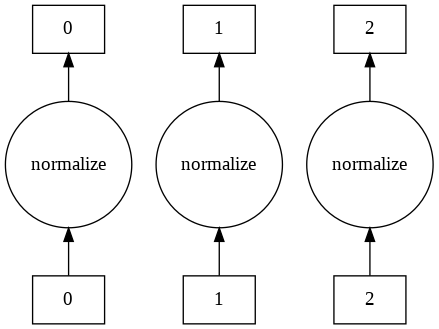

In [ ]:
dask.visualize(clean_body_train)

In [ ]:
more_text = clean_body_train.compute()


In [ ]:
more_text[0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [ ]:
reviews_list_test = data['test']['text']
review_bag_test = db.from_sequence(reviews_list_test, npartitions=3)
clean_body_test = review_bag_test.map(normalize,top_5000_words=top_5000_words)


In [ ]:
more_text_test = clean_body_test.compute()

In [ ]:
more_text_test[0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [ ]:
data['train'] = data['train'].add_column(name="cleaned_reviews", column=more_text)
data['test'] = data['test'].add_column(name="cleaned_reviews", column=more_text_test)

In [ ]:
data['train']['cleaned_reviews'][0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [ ]:
data['test']['cleaned_reviews'][0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
})

## Tokenizing

In [ ]:
from transformers import AutoTokenizer

In [ ]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['cleaned_reviews'], truncation=True,padding=True) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

## Config File

In [ ]:
from transformers import AutoConfig

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

In [ ]:
target_map = {'negative': 0,  'positive': 1}

In [ ]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [ ]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [ ]:
config.id2label = {v:k for k,v in target_map.items()}
config.id2label

{0: 'negative', 1: 'positive'}

In [ ]:
config.label2id = target_map
config.label2id

{'negative': 0, 'positive': 1}

## Modeling

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt =  'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=3

In [ ]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

## Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
## Training Arguments
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "real_airline_tweet_analysis_model"
training_args = TrainingArguments(
    'airline_tweet_lp_real',
    evaluation_strategy='epoch',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

## Custom Metric Function

In [ ]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

## Training

In [ ]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.328400,0.261197,0.891960,"(0.8918720497633057,)"
2,0.204800,0.277898,0.898080,"(0.8980512259780201,)"


TrainOutput(global_step=3126, training_loss=0.2666767463040367, metrics={'train_runtime': 1825.5682, 'train_samples_per_second': 27.389, 'train_steps_per_second': 1.712, 'total_flos': 6623369932800000.0, 'train_loss': 0.2666767463040367, 'epoch': 2.0})